# Transfer Learning avec **MobileNetV2**

In [ ]:
!pip show tensorflow
!pip show keras

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras
Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from collections import Counter
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
import os


drive.mount('/content/drive')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = "/content/drive/MyDrive/Projet-ML/dataset_corrige_animals"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dir_path = DATASET_PATH
class_counts = {}

for class_name in os.listdir(dir_path):
    class_dir = os.path.join(dir_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

print(class_counts)

{'injured_animals': 261, 'not_injured_animals': 282}


# Création de datasets train / val

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Augmentation des données

In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

## Exemple d'une image transformée avec le bloc data_augmentation

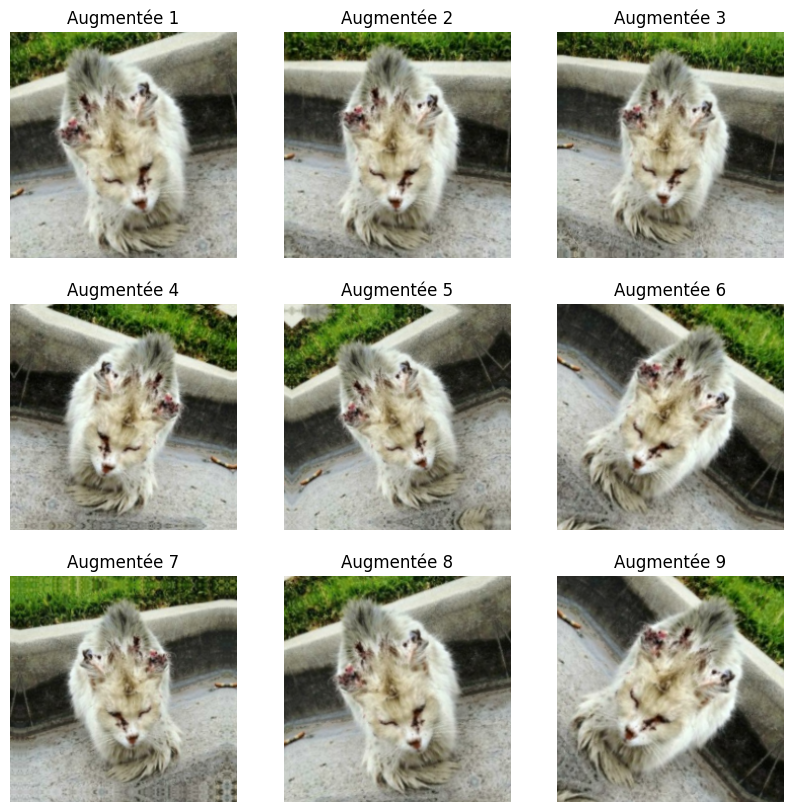

In [6]:
import numpy as np

for images, _ in train_ds.take(1):
    sample_image = images[0]
    break

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.cast(augmented_image[0], tf.uint8))
    plt.title(f"Augmentée {i+1}")
    plt.axis("off")
plt.show()

# Chargement de MobileNetV2 sans les couches de classification (top)

In [4]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False)

base_model.trainable = True
#for layer in base_model.layers[:-30]:
 #   layer.trainable = False


model = models.Sequential([
    layers.Rescaling(1./255),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# Entraînement
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

# Exemple d'une image transformée avec le bloc data_augmentation

# Entrainement du modèle

In [5]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 158s 8s/step - accuracy: 0.5642 - auc: 0.5856 - loss: 0.7127 - precision: 0.6118 - recall: 0.5011 - val_accuracy: 0.5556 - val_auc: 0.5525 - val_loss: 0.7384 - val_precision: 0.5571 - val_recall: 0.6964
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.5059 - auc: 0.5181 - loss: 0.7354 - precision: 0.5049 - recall: 0.4969 - val_accuracy: 0.5833 - val_auc: 0.5810 - val_loss: 0.7255 - val_precision: 0.5753 - val_recall: 0.7500
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.5333 - auc: 0.5521 - loss: 0.7127 - precision: 0.5531 - recall: 0.6227 - val_accuracy: 0.5926 - val_auc: 0.6238 - val_loss: 0.6907 - val_precision: 0.5811 - val_recall: 0.7679
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 0.5582 - auc: 0.5770 - loss: 0.6992 - precision: 0.6005 - recall: 0.5466 - val_accuracy: 0.6111 - val_auc: 0.6526 - val_loss: 0.6716 - val_precision: 0.5946 - val_recall: 0.7857
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━

# Les courbes de Précision et de Pertes

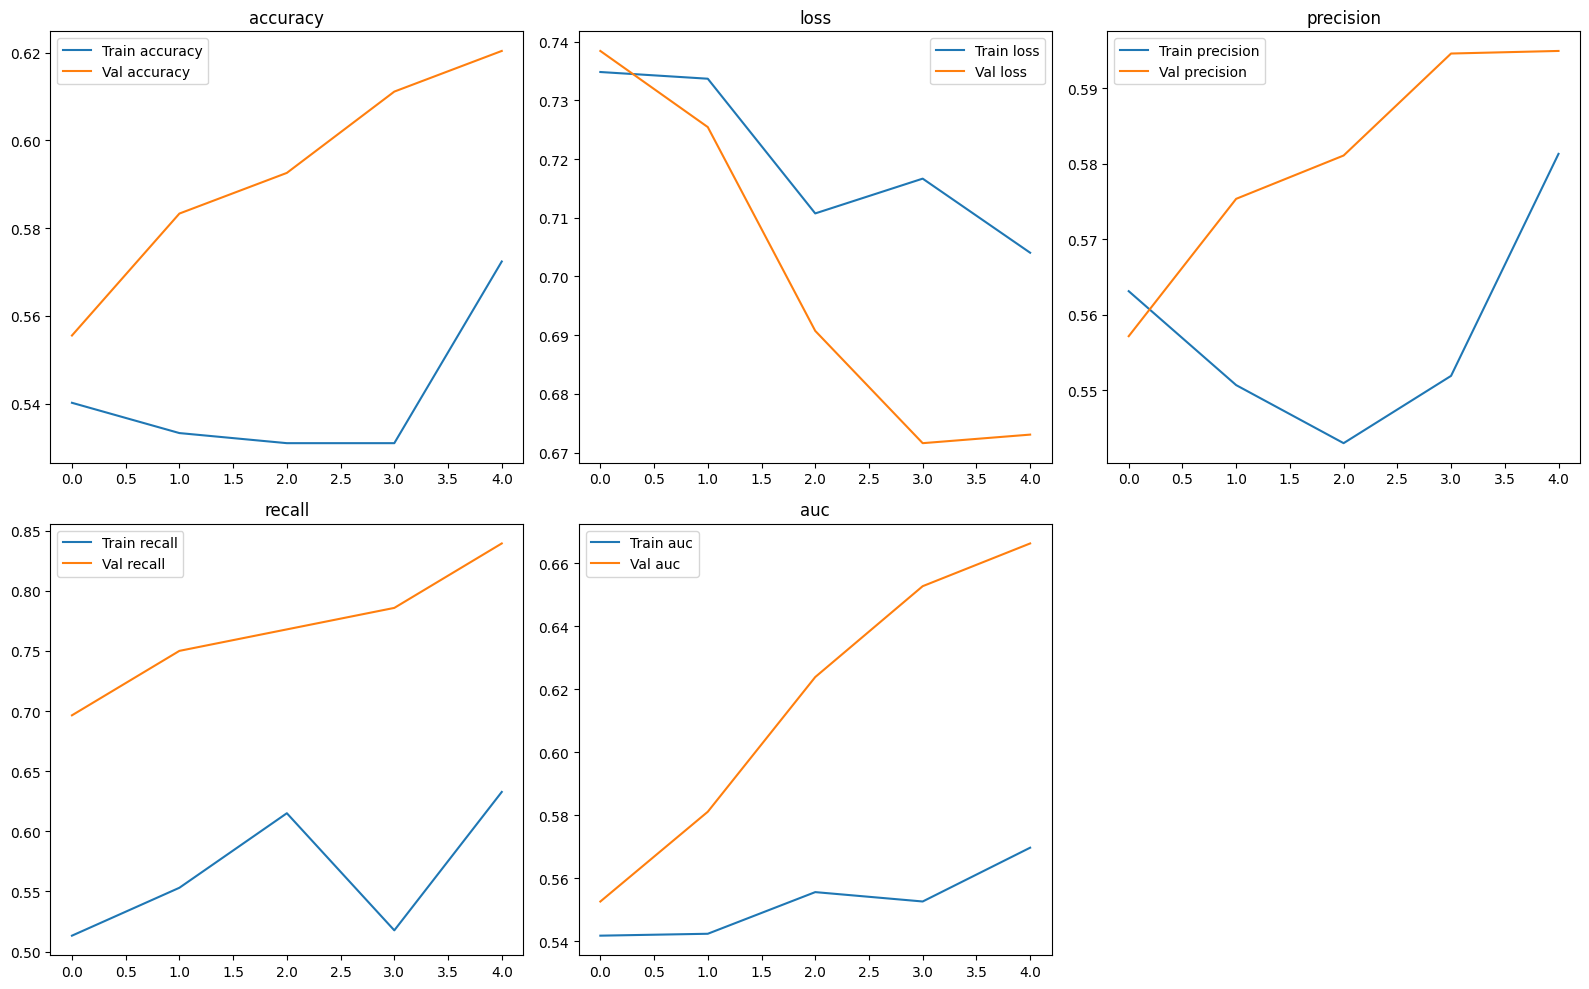

In [6]:
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    plt.figure(figsize=(16, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.legend()
        plt.title(metric)
    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

# Évaluation sur test

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(test_ds)
print(f"\nTest set: Accuracy={test_acc:.3f}, Precision={test_prec:.3f}, Recall={test_rec:.3f}, AUC={test_auc:.3f}")

# Matrice de confusion

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend((preds > 0.5).astype("int32").flatten())
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Non blessé', 'Blessé'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice de confusion (Test)")
plt.show()

# Enregistrement du modèle

In [ ]:
model_tl.save("Aminata_MobileNetV2.h5")

In [7]:
from tensorflow.keras.models import load_model

model_tl = load_model("/content/drive/MyDrive/Projet-ML/Aminata_MobileNetV2 - Version2.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<Figure size 600x600 with 0 Axes>

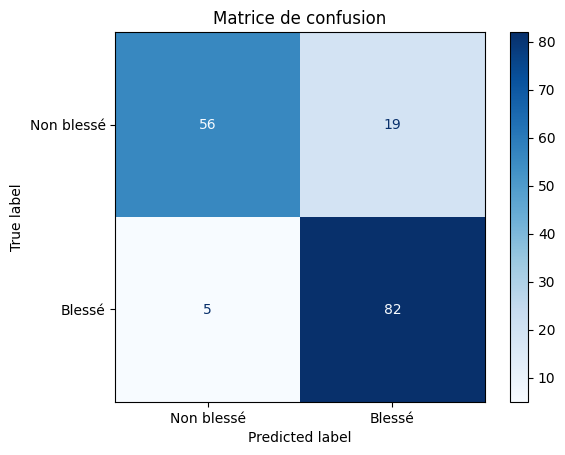

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model_tl.predict(images)
    preds_classes = (preds > 0.5).astype("int32")  # Seuil à 0.5
    y_true.extend(labels.numpy())
    y_pred.extend(preds_classes.flatten())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non blessé', 'Blessé'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice de confusion")
plt.show()


In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Extraire les features à partir du modèle MobileNetV2 sans la dernière couche
feature_extractor = tf.keras.Model(inputs=model_tl.input, outputs=model_tl.layers[-3].output)

features = []
labels = []

for images, label in train_ds:
    feats = feature_extractor.predict(images)
    features.append(feats)
    labels.append(label)

features = np.concatenate(features)
labels = np.concatenate(labels)

# Réduction de dimension
reduced = PCA(n_components=50).fit_transform(features)
tsne = TSNE(n_components=2, perplexity=30).fit_transform(reduced)

# Clustering
kmeans = KMeans(n_clusters=2)  # ou plus si plusieurs espèces
clusters = kmeans.fit_predict(tsne)

# Visualisation
plt.scatter(tsne[:, 0], tsne[:, 1], c=clusters, cmap='viridis')
plt.title("Clustering d’images animales")
plt.show()

AttributeError: The layer sequential_1 has never been called and thus has no defined input.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')